In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to calculate the image width and height in each for different sizes of kernels and different out channels
def img_size(img_w, filter_size, padding, stride):
    return (1 / 2) * (1 + (img_w - filter_size + (2 * padding)) / stride)

class ConvNet(nn.Module):
    def __init__(self, in_channels=3, num_filters=[32, 64, 128, 256, 512], filter_size=[3, 3, 5, 5, 7],
                 activation=nn.ReLU(), stride=1, padding=1, pool_size=(2, 2), fc_size=512, num_classes=10,
                 dropout=0, batch_norm = 'Yes'):
        super(ConvNet, self).__init__()
        self.channels = in_channels
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.activation = activation
        self.stride = stride
        self.padding = padding
        self.pool_size = pool_size
        self.fc_size = fc_size
        self.num_classes = num_classes
        self.dropout = dropout
        self.batch_norm = batch_norm

        # Define convolutional layers
        self.conv1 = nn.Conv2d(self.channels, self.num_filters[0], self.filter_size[0], stride=self.stride, padding=self.padding)
        self.dropout1 = nn.Dropout2d(self.dropout)
        self.conv2 = nn.Conv2d(self.num_filters[0], self.num_filters[1], self.filter_size[1], stride=self.stride,padding=self.padding)
        self.dropout2 = nn.Dropout2d(self.dropout)
        self.conv3 = nn.Conv2d(self.num_filters[1], self.num_filters[2], self.filter_size[2], stride=self.stride,padding=self.padding)
        self.dropout3 = nn.Dropout2d(self.dropout)
        self.conv4 = nn.Conv2d(self.num_filters[2], self.num_filters[3], self.filter_size[3], stride=self.stride,padding=self.padding)
        self.dropout4 = nn.Dropout2d(self.dropout)
        self.conv5 = nn.Conv2d(self.num_filters[3], self.num_filters[4], self.filter_size[4], stride=self.stride,padding=self.padding)
        self.dropout5 = nn.Dropout2d(self.dropout)

        # Define batch normalization layers
        self.batchnorm1 = nn.BatchNorm2d(self.num_filters[0])
        self.batchnorm2 = nn.BatchNorm2d(self.num_filters[1])
        self.batchnorm3 = nn.BatchNorm2d(self.num_filters[2])
        self.batchnorm4 = nn.BatchNorm2d(self.num_filters[3])
        self.batchnorm5 = nn.BatchNorm2d(self.num_filters[4])

        # Define activation function
        self.activation = activation

        # Define max pooling layers
        self.pool = nn.MaxPool2d(self.pool_size, stride=2)  # for maxpool default stride is 2 and padding is 0


        # Calculating image width and height after each layer
        nxt_size1 = img_size(224, self.filter_size[0], self.padding, self.stride)
        nxt_size2 = img_size(nxt_size1, self.filter_size[1], self.padding, self.stride)
        nxt_size3 = img_size(nxt_size2, self.filter_size[2], self.padding, self.stride)
        nxt_size4 = img_size(nxt_size3, self.filter_size[3], self.padding, self.stride)
        nxt_size5 = img_size(nxt_size4, self.filter_size[4], self.padding, self.stride)
        nxt_size5 = int(nxt_size5)

        # Define dropout layer
        self.dropout_layer = nn.Dropout1d(self.dropout)

        # Define fully connected layer
        self.fc = nn.Linear(self.num_filters[4] * (nxt_size5 ** 2), self.fc_size)
        self.fc_bn = nn.BatchNorm1d(self.fc_size)  # Batch normalization for fully connected layer

        # Output layer
        self.output_layer = nn.Linear(self.fc_size, self.num_classes)

    # Forward propagation function
    def forward(self, x):
        # 1st conv layer
        x = self.conv1(x)
        if self.batch_norm == 'Yes':
            x = self.batchnorm1(x)
        else:
            x = x
        x = self.activation(x)
        x = self.pool(x)
        x = self.dropout1(x)


        # 2nd conv layer
        x = self.conv2(x)
        if self.batch_norm == 'Yes':
            x = self.batchnorm2(x)
        else:
            x = x
        # x = self.batchnorm2(x)
        x = self.activation(x)
        x = self.pool(x)
        x = self.dropout2(x)


        # 3rd conv layer
        x = self.conv3(x)
        if self.batch_norm == 'Yes':
            x = self.batchnorm3(x)
        else:
            x = x
        x = self.activation(x)
        x = self.pool(x)
        x = self.dropout3(x)


        # 4th conv layer
        x = self.conv4(x)
        if self.batch_norm == 'Yes':
            x = self.batchnorm4(x)
        else:
            x = x
        x = self.activation(x)
        x = self.pool(x)
        x = self.dropout4(x)

        # 5th conv layer
        x = self.conv5(x)
        if self.batch_norm == 'Yes':
            x = self.batchnorm5(x)
        else:
            x = x
        x = self.activation(x)
        x = self.pool(x)
        x = self.dropout5(x)

        # Flatten the output for the fully connected layer
        x = x.reshape(x.size(0), -1)
#         x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc(x)
        # Batch normalization before activation
        if self.batch_norm == 'Yes':
            x = self.fc_bn(x)
        else:
            x = x
        # x = self.fc_bn(x)
        x = self.activation(x)
        # Apply dropout
        x = self.dropout_layer(x)
        # Output layer
        x = self.output_layer(x)

        return x

# Making object of the ConvNet class
model = ConvNet().to(device)
print(model)

ConvNet(
  (activation): ReLU()
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout2d(p=0, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout2): Dropout2d(p=0, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (dropout3): Dropout2d(p=0, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (dropout4): Dropout2d(p=0, inplace=False)
  (conv5): Conv2d(256, 512, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
  (dropout5): Dropout2d(p=0, inplace=False)
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True,

In [2]:
# Function to train the model on train data
def train_on_train_data(model, train_data):
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.train()  # Set the model to training mode
    training_loss = 0.0
    correct_train_label = 0
    total_train = 0
    # Training loop
    for inputs, labels in train_data:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()

        # Calculate training accuracy
        _, pred = torch.max(outputs, 1)
        correct_train_label += (pred == labels).sum().item()
        total_train += labels.size(0)

    # Calculate training loss and accuracy
    avg_loss = training_loss / len(train_data)
    train_accuracy = 100 * correct_train_label / total_train
    return model, avg_loss, train_accuracy


In [3]:
 # Function to test the model
def test_on_valid_data(model, test_data):
    model.eval()  # Set the model to evaluation mode
    correct_val_label = 0
    total_val_label = 0
    with torch.no_grad():  # Turn off gradient calculation for validation
        for img, label in test_data:
            img, label = img.to(device), label.to(device)
            output = model(img)
            _, pred = torch.max(output, 1)
            correct_val_label += (pred == label).sum().item()
            total_val_label += label.size(0)

    # Calculate validation accuracy
    valid_accuracy = 100 * correct_val_label / total_val_label
    return valid_accuracy


In [4]:
# Function to training model
def model_train_val(model, train_data, val_data,epochs):

    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model, avg_loss, train_accuracy = train_on_train_data(model, train_data)
        # Print training loss and accuracy
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
        wandb.log({'Train loss': avg_loss})
        wandb.log({'Train accuracy': train_accuracy})

        # Validation loop
        val_accuracy = test_on_valid_data(model, val_data)
        # Print validation accuracy
        print(f'Epoch {epoch+1}/{epochs}, Validation Accuracy: {val_accuracy:.2f}%')
        wandb.log({'val_accuracy': val_accuracy})
        wandb.log({'epoch': epoch})

    print('Training complete!')

# Example usage
# model_train(model, train_loader, val_loader)

In [5]:
# Training data loader function

train_data_dir = '/content/drive/MyDrive/DA6401_Assignment-2/inaturalist_12K/train'

def data_load(train_data_dir,data_augumentation):

    # Define variables to transeform the images to tensor and for data augumentation
    resize = transforms.Resize((224, 224))
    convert_to_tensor = transforms.ToTensor()
    normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    resize_crop = transforms.RandomResizedCrop(224)
    h_flip = transforms.RandomHorizontalFlip()
    color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
    rand_rotation = transforms.RandomRotation(20)

    # Data augumentation
    if data_augumentation == 'Yes':
        transform_img = transforms.Compose([resize_crop,h_flip,color_jitter, rand_rotation, convert_to_tensor,normalize]) # Data transformations

    else:
        transform_img = transforms.Compose([resize,convert_to_tensor, normalize ])  # Data transformations

    # Load the dataset using ImageFolder and apply transformations
    training_data = ImageFolder(root=train_data_dir, transform=transform_img)
    # Splitting train dataset into training and validation indices
    train_index, val_index = train_test_split(list(range(len(training_data))), test_size=0.2, random_state=42)
    # Create DataLoader instances for training and validation sets
    random_train_sample = SubsetRandomSampler(train_index)
    train_data = DataLoader(training_data, batch_size=32, sampler=random_train_sample)
    random_val_sample = SubsetRandomSampler(val_index)
    validation_data = DataLoader(training_data, batch_size=32, sampler=random_val_sample)
    return train_data, validation_data

In [6]:
# Test data loader function
test_data_dir = '/content/drive/MyDrive/DA6401_Assignment-2/inaturalist_12K/val'

def test_data_load(test_data_dir,data_augumentation):
    # Define variables to transeform the images to tensor and for data augumentation
    resize = transforms.Resize((224, 224))
    convert_to_tensor = transforms.ToTensor()
    normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    resize_crop = transforms.RandomResizedCrop(224)
    h_flip = transforms.RandomHorizontalFlip()
    color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
    rand_rotation = transforms.RandomRotation(20)

    # Data augumentation
    if data_augumentation == 'Yes':
        transform_img = transforms.Compose([resize_crop,h_flip,color_jitter, rand_rotation, convert_to_tensor,normalize]) # Data transformations

    else:
        transform_img = transforms.Compose([resize,convert_to_tensor, normalize ])  # Data transformations

    # Load the dataset using ImageFolder and apply transformations
    test_data = ImageFolder(root=test_data_dir, transform=transform_img)
    # Apply DataLoader to load the test data with batch sizes
    testData = DataLoader(test_data, batch_size=32)

    return testData


In [7]:
import wandb
import numpy as np
from types import SimpleNamespace
import random


In [8]:
wandb.login(key='f5557fe014798eefe63f9822700bf01578424638')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mdkarimullahaque (mdkarimullahaque-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [9]:
sweep_config = {
    'method': 'bayes',
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'
    },
    'parameters': {
        'kernel_size':{
            'values': [[3,3,3,3,3],[3,5,5,7,7],[3,5,3,5,7],[5,5,5,5,5]]#,[7,7,7,7,7]]
        },
        'dropout': {
            'values': [0.3, 0.2]
        },
        'activation': {
            'values': [ 'relu','mish','silu', 'gelu',]
        },
        'num_dense':{
            'values': [128, 256]
        },
        'batch_norm':{
            'values': ['Yes','No']
        },
        'filter_org':{
            'values': [[128,128,64,64,32],[32,64,128,256,512],[32,32,32,32,32],[32,64,64,128,128]]
        },
        'data_aug': {
            'values': ['No', 'Yes']
        }
    }
}

sweep_id = wandb.sweep(sweep=sweep_config, project='DL_assignment_2')

Create sweep with ID: vrbizrdl
Sweep URL: https://wandb.ai/mdkarimullahaque-iit-madras/DL_assignment_2/sweeps/vrbizrdl


In [10]:
def main():
    '''
    WandB calls main function each time with differnet combination.

    We can retrive the same and use the same values for our hypermeters.

    '''

    with wandb.init() as run:
        run_name="ks"+str(wandb.config.kernel_size)+"ac-"+(wandb.config.activation)+"_drop-"+str(wandb.config.dropout)+"_daug-"+str(wandb.config.data_aug)+"_fs-"+str(wandb.config.filter_org)+"_bn-"+str(wandb.config.batch_norm)+"_dence-"+str(wandb.config.num_dense)
        wandb.run.name=run_name

        if  wandb.config.activation == 'relu':
            activ=nn.ReLU()
        elif wandb.config.activation == 'gelu':
            activ=nn.GELU()
        elif wandb.config.activation == 'silu':
            activ=nn.SiLU()
        elif wandb.config.activation == 'mish':
            activ=nn.Mish()

        model = ConvNet(in_channels=3, num_filters=wandb.config.filter_org, filter_size=wandb.config.kernel_size, activation=activ, stride=1,
                        padding=1, pool_size=(2,2), fc_size=wandb.config.num_dense, num_classes=10,dropout = wandb.config.dropout,batch_norm=wandb.config.batch_norm).to(device)

        train_data_dir = '/content/drive/MyDrive/DA6401_Assignment-2/inaturalist_12K/train'
        train, validation = data_load(train_data_dir,data_augumentation= wandb.config.data_aug)

        model_train_val(model, train, validation, epochs = 7)

#         model_train(model,train,validation)

wandb.agent(sweep_id, function= main,count= 1) # calls main function for count number of times.
wandb.finish()

wandb: Agent Starting Run: tzouly2t with config:
wandb: 	activation: mish
wandb: 	batch_norm: No
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	filter_org: [128, 128, 64, 64, 32]
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	num_dense: 256


Epoch 1/7, Train Loss: 2.2172, Train Accuracy: 17.40%
Epoch 1/7, Validation Accuracy: 26.80%
Epoch 2/7, Train Loss: 2.1493, Train Accuracy: 21.09%
Epoch 2/7, Validation Accuracy: 29.00%
Epoch 3/7, Train Loss: 2.1018, Train Accuracy: 23.98%
Epoch 3/7, Validation Accuracy: 27.90%
Epoch 4/7, Train Loss: 2.0761, Train Accuracy: 24.34%
Epoch 4/7, Validation Accuracy: 30.60%
Epoch 5/7, Train Loss: 2.0459, Train Accuracy: 25.25%
Epoch 5/7, Validation Accuracy: 31.90%
Epoch 6/7, Train Loss: 2.0362, Train Accuracy: 26.65%
Epoch 6/7, Validation Accuracy: 30.65%
Epoch 7/7, Train Loss: 2.0072, Train Accuracy: 26.89%
Epoch 7/7, Validation Accuracy: 30.25%
Training complete!


Train accuracy,▁▄▆▆▇██
Train loss,█▆▄▃▂▂▁
epoch,▁▂▃▅▆▇█
val_accuracy,▁▄▃▆█▆▆
Train accuracy,26.89086
Train loss,2.00719
epoch,6
val_accuracy,30.25


In [11]:
num_filters=[128, 128, 64, 64, 32]
filter_size=[3, 3, 3, 3, 3]
activation=nn.Mish()
fc_size=128
dropout=0.3
batch_norm = 'Yes'
data_augumentation = 'No'
epochs = 6


In [12]:
test_data_dir = '/content/drive/MyDrive/DA6401_Assignment-2/inaturalist_12K/val'

test_dataset = test_data_load(test_data_dir,data_augumentation)

train_data_dir = '/content/drive/MyDrive/DA6401_Assignment-2/inaturalist_12K/train'

train_data , validation_data =  data_load(train_data_dir,data_augumentation)


In [18]:
import imageio.v2
import os
import cv2
from PIL import Image
import io

def img_plot(model):
    #For plotting random Images
    classes_list = ['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']
    # Directory of the test data
    dir = '/content/drive/MyDrive/DA6401_Assignment-2/inaturalist_12K/val'
    images = []  # List to store the images
    labels = []  #  List to store the labels

    for label, name in enumerate(classes_list):
      images_list = os.listdir(dir+'/'+name)
      img_names = []
      for j in range(3):
        index = random.randint(0, 199)
        img_names.append(images_list[index])
      for image_name in img_names:
          image = imageio.v2.imread(dir+'/'+name+'/'+image_name)
          if np.ndim(image) == 3:
            images.append(cv2.resize(image, (224,224)))
            labels.append(classes_list[label])

    arr = np.array(images)
    arr = (arr/255.0).astype('float32')
    transp_arr = np.transpose(arr, (0, 3, 1, 2))
    tensor1 = torch.tensor(transp_arr).to(device)
    y_pred = model(tensor1)
    y_pred_label = torch.argmax(y_pred, 1)
    dictn = {0:'Amphibia',1:'Animalia',2:'Arachnida',3:'Aves',4:'Fungi',
               5:'Insecta',6:'Mammalia',7:'Mollusca',8:'Plantae',9:'Reptilia'}

    fig, axes = plt.subplots(10, 3, figsize=(12, 20))
    for i in range(10):
        for j in range(3):
            ind = i * 3 + j
            if ind < 30:
                axes[i, j].imshow(images[ind])
                axes[i, j].set_title(f'True: {labels[ind]}, Predicted: {dictn[y_pred_label[ind].item()]}')
                axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

    # Save the figure to a buffer and then load it as a PIL Image
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    image = Image.open(buf)

    wandb.log({"images": [wandb.Image(image, caption="Test image prediction")]})

In [14]:
import imageio.v2
import os
import cv2
from PIL import Image

classes1 = {0:'Amphibia',1:'Animalia',2:'Arachnida',3:'Aves',4:'Fungi',
           5:'Insecta',6:'Mammalia',7:'Mollusca',8:'Plantae',9:'Reptilia'}
# Function to training model

model = ConvNet(in_channels=3, num_filters=[128, 128, 64, 64, 32], filter_size=[3, 3, 3, 3, 3],
                 activation=nn.Mish(), stride=1, padding=1, pool_size=(2, 2), fc_size=128, num_classes=10,
                 dropout=0.3, batch_norm = 'Yes').to(device)

def model_train_test(model, train_data, test_data,epochs):

    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(epochs):
        model, avg_loss, train_accuracy = train_on_train_data(model, train_data)
        # Print training loss and accuracy
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
        wandb.log({'Train loss': avg_loss})
        wandb.log({'Train accuracy': train_accuracy})


    # Validation loop
    val_accuracy = test_on_valid_data(model, test_data)
    # calling function to plotting Image
    img_plot(model)

    # Print validation accuracy
    print(f'Epoch {epoch+1}/{epochs}, Validation Accuracy: {val_accuracy:.2f}%')
    wandb.log({'test_accuracy': val_accuracy})
    wandb.log({'epoch': epoch})
    wandb.finish()

    print('Training complete!')

# model_train_test(model, train_data, test_dataset,epochs=1)

In [15]:
sweep_config = {
    'method': 'bayes',
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'
    },
    'parameters': {
        'kernel_size':{
            'values': [[3,3,3,3,3]]
        },
        'dropout': {
            'values': [0.3]
        },
        'activation': {
            'values': [ 'mish']
        },
        'num_dense':{
            'values': [128]
        },
        'batch_norm':{
            'values': ['Yes']
        },
        'filter_org':{
            'values': [[128,128,64,64,32],[32,32,32,32,32]]
        },
        'data_aug': {
            'values': ['No']
        }
    }
}

sweep_id = wandb.sweep(sweep=sweep_config, project='DL_assignment_2')

Create sweep with ID: 46nz7r8s
Sweep URL: https://wandb.ai/mdkarimullahaque-iit-madras/DL_assignment_2/sweeps/46nz7r8s


wandb: Agent Starting Run: m39e14gp with config:
wandb: 	activation: mish
wandb: 	batch_norm: Yes
wandb: 	data_aug: No
wandb: 	dropout: 0.3
wandb: 	filter_org: [128, 128, 64, 64, 32]
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	num_dense: 128


Epoch 1/6, Train Loss: 2.2172, Train Accuracy: 17.73%
Epoch 2/6, Train Loss: 2.1645, Train Accuracy: 19.91%
Epoch 3/6, Train Loss: 2.1216, Train Accuracy: 21.83%
Epoch 4/6, Train Loss: 2.0973, Train Accuracy: 23.25%
Epoch 5/6, Train Loss: 2.0749, Train Accuracy: 23.82%
Epoch 6/6, Train Loss: 2.0699, Train Accuracy: 23.24%


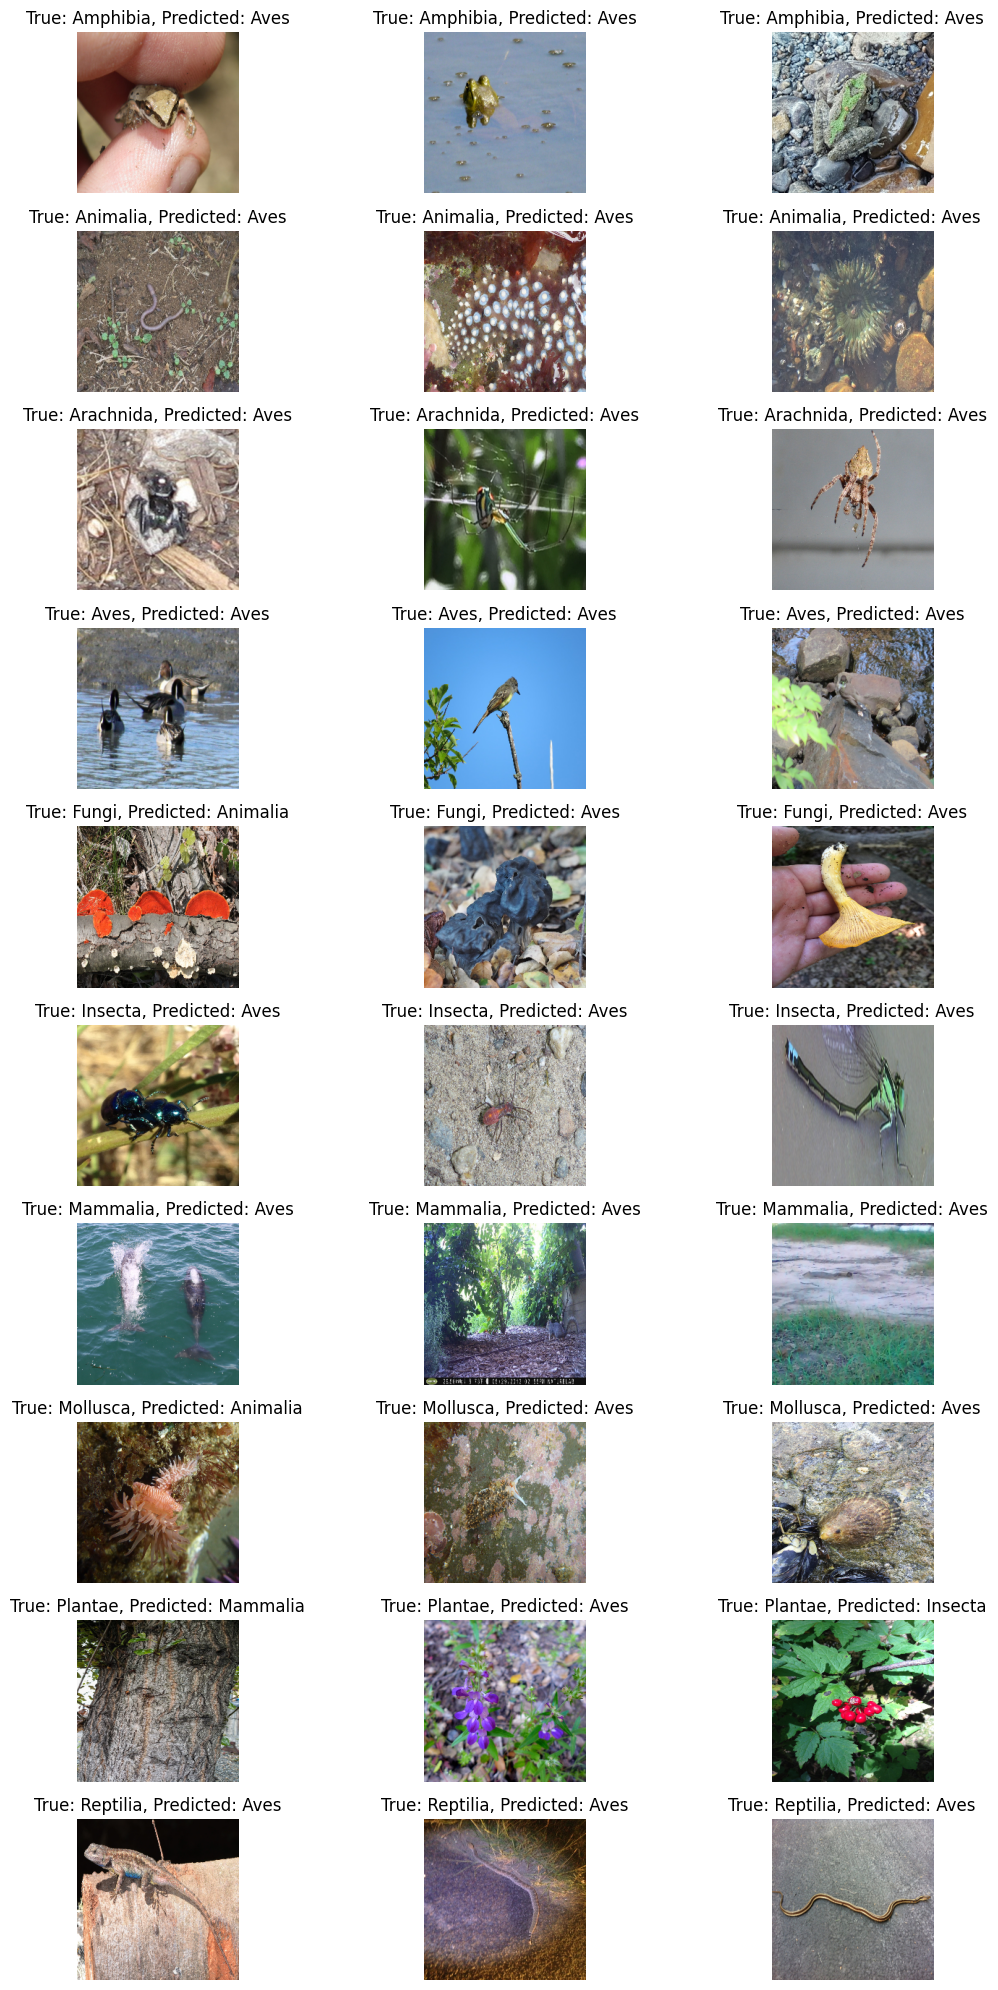

Traceback (most recent call last):
  File "<ipython-input-17-b45fe4bc18b4>", line 32, in main
    model_train_test(model, train_data, test_data,epochs = 6)
  File "<ipython-input-14-a9110a4adea9>", line 30, in model_train_test
    img_plot(model)
  File "<ipython-input-18-18dd30713802>", line 45, in img_plot
    image = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())
                                                                  ^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'FigureCanvasAgg' object has no attribute 'tostring_rgb'


Train accuracy,▁▄▆▇█▇
Train loss,█▅▃▂▁▁
Train accuracy,23.24041
Train loss,2.06989


wandb: ERROR Run m39e14gp errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "<ipython-input-17-b45fe4bc18b4>", line 32, in main
wandb: ERROR     model_train_test(model, train_data, test_data,epochs = 6)
wandb: ERROR   File "<ipython-input-14-a9110a4adea9>", line 30, in model_train_test
wandb: ERROR     img_plot(model)
wandb: ERROR   File "<ipython-input-18-18dd30713802>", line 45, in img_plot
wandb: ERROR     image = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())
wandb: ERROR                                                                   ^^^^^^^^^^^^^^^^^^^^^^^
wandb: ERROR AttributeError: 'FigureCanvasAgg' object has no attribute 'tostring_rgb'
wandb: ERROR 


In [19]:
def main():
    '''
    WandB calls main function each time with differnet combination.

    We can retrive the same and use the same values for our hypermeters.

    '''

    with wandb.init() as run:
        run_name="ks"+str(wandb.config.kernel_size)+"ac-"+(wandb.config.activation)+"_drop-"+str(wandb.config.dropout)+"_daug-"+str(wandb.config.data_aug)+"_fs-"+str(wandb.config.filter_org)+"_bn-"+str(wandb.config.batch_norm)+"_dence-"+str(wandb.config.num_dense)
        wandb.run.name=run_name

        if  wandb.config.activation == 'relu':
            activ=nn.ReLU()
        elif wandb.config.activation == 'gelu':
            activ=nn.GELU()
        elif wandb.config.activation == 'silu':
            activ=nn.SiLU()
        elif wandb.config.activation == 'mish':
            activ=nn.Mish()

        model = ConvNet(in_channels=3, num_filters=wandb.config.filter_org, filter_size=wandb.config.kernel_size, activation=activ, stride=1,
                        padding=1, pool_size=(2,2), fc_size=wandb.config.num_dense, num_classes=10,dropout = wandb.config.dropout,batch_norm=wandb.config.batch_norm).to(device)


        train_data_dir = '/content/drive/MyDrive/DA6401_Assignment-2/inaturalist_12K/train'
        train_data, validation = data_load(train_data_dir,data_augumentation= wandb.config.data_aug)

        test_data_dir = '/content/drive/MyDrive/DA6401_Assignment-2/inaturalist_12K/val'
        test_data = test_data_load(test_data_dir,data_augumentation = wandb.config.data_aug)
        # Callig model train function
        model_train_test(model, train_data, test_data,epochs = 6)
wandb.agent(sweep_id, function= main,count= 1) # calls main function for count number of times.
wandb.finish()